## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
len(df)

294478

c. The number of unique users in the dataset.

In [4]:
len(df['user_id'].value_counts())

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
count1 = df.query('group != "control" and landing_page =="old_page"').count()[0]
count2 = df.query('group != "treatment" and landing_page =="new_page"').count()[0]


count1 + count2


3893

f. Do any of the rows have missing values?

In [7]:
dfisNull=pd.isnull(df)
dfisNull.sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# i need to drop the rows where treatment is not aligned with new_page or control.

ind = df[ (df.group != "control") & (df.landing_page == "old_page") ].index 
ind2 =df[ (df.group != "treatment") & (df.landing_page == "new_page") ].index
df.drop(ind , inplace=True)
df.drop(ind2 , inplace=True)
df2=df

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
len(df2['user_id'].value_counts())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2['user_id'].duplicated(keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
duplicateDF = df2[df2['user_id'].duplicated(keep=False)]
duplicateDF

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop(1899,inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

In [15]:
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
ControlM=df2.query('group == "control"')['converted'].mean()
ControlM

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
TreatmentM=df2.query('group == "treatment"')['converted'].mean()
TreatmentM

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2.query('landing_page == "new_page"').count()[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

### Answer:
**there is no significant difference with this result to prove that the new page leads to new conversion , both Groups have the same probabilities 0.5 to receive the new page**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null hypothesis should be that old page is more or equally better than new page. Alternative hypothesis is new page is better than old page.


Alternative  H1 : **$p_{new}$** > **$p_{old}$**

Null H0 : **$p_{new}$** <= **$p_{old}$**


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
# the Pnew and Pold are the same.
Pnew=df2.converted.mean()
Pnew

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
POld= df2.converted.mean()
POld

0.11959708724499628

c. What is $n_{new}$?

In [21]:

Nnew=df2.query('group == "treatment"').count()[0]
Nnew

#also the line below will show the Number of records for each Group control & treatment.
#Nnew=df.groupby(['group'])['user_id'].nunique()

145310

d. What is $n_{old}$?

In [22]:
Nold=df2.query('group == "control"').count()[0]
Nold

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:

new_page_converted = np.random.binomial(n=1,p=Pnew,size=Nnew).mean()
new_page_converted

0.12116853623288143

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.binomial(n=1,p=POld,size=Nold).mean()
old_page_converted

0.12062034500323526

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted - old_page_converted

0.0005481912296461666

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
# i used Numpy Binomial as suggested by the reviewer which is much faster than Looping 10000 times.

p_diffs=[]
new_converted = np.random.binomial(Nnew, Pnew, 10000)/Nnew
old_converted = np.random.binomial(Nold, POld, 10000)/Nold
p_diffs = new_converted - old_converted

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

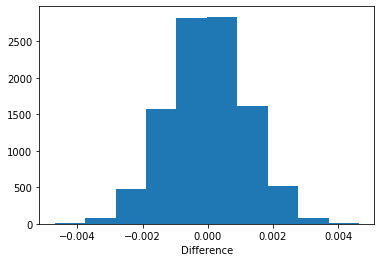

In [28]:
plt.hist(p_diffs)
plt.xlabel('Difference');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
# Acctual Diff is the treatment mean minus the control mean
Acctual_Diff = TreatmentM - ControlM
(p_diffs > Acctual_Diff).mean()

0.9058

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**this is the P-Value ,the result made a significant difference with a large sample size.
Fail to reject the Null the old page is slightly better than the new page**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

convert_old = len(df2.query('group == "control" and converted ==1')['user_id'])
convert_new = len(df2.query('group == "treatment" and converted ==1')['user_id'])
n_old = df2.query('group == "control"').count()[0]
n_new = df2.query('group == "treatment"').count()[0] 
convert_old,convert_new,n_new,n_old

(17489, 17264, 145310, 145274)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [31]:

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**it show's the same result. and this confirm that the null hypothesis is true and that the old page is better than the new one.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**i will use logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df3=df2
df3['intercept'] = 1

In [33]:

df3['intercept'] = 1

df3[['ab_page','control']] = pd.get_dummies(df['group'])

df3 = df3.drop('control', axis=1)


In [34]:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [35]:

import statsmodels.api as sm

logit = sm.Logit(df3['converted'],df2[['intercept' ,'ab_page']])


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 28 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        15:45:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
ab_page        0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The P-Value is 0.190 . the diffrence in value is in part 2 we test a large sample where in part 3 we tested wither the value is equal to or not.**

**$$ H_0: p_{new} = p_{old} $$$$ H_1: p_{new} \neq p_{old} $$**



f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Yes Adding more factors like age , major might influence an individual to converts to the new page**

**Disadvantages: some factors may affect the result when compaind in groups (Simpson's paradox)**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')


In [38]:
df_new['intercept'] = 1

df_new[['CA','US']] = pd.get_dummies(df_new['country'])[['CA','US']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,control,CA,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,0


In [39]:
logit = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US']])

results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 28 Jul 2020   Pseudo R-squ.:               1.521e-05
Time:                        15:46:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [40]:
df_new['CA_ab_page'] = df_new['CA'] * df_new['ab_page']
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']

df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,control,CA,US,CA_ab_page,US_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,0,0,0


In [43]:
logit = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US','CA_ab_page','US_ab_page']])

results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Tue, 28 Jul 2020   Pseudo R-squ.:               3.376e-05
Time:                        15:48:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1265
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0846      0.039     -2.179      0.029      -0.161      -0.009
US            -0.0202      0.015     -1.351      0.177      -0.050       0.009
CA_ab_page     0.0674      0.052      1.297      0.195      -0.034       0.169
US_ab_page     0.0206      0.014      1.505      0.132      -0.006       0.047
==============================================================================
"""

**the p-Value is still higher than 0.05 which means that there is no correlation between adding country factor and converting to the new page.**

**this mean more people are still using the old page, and US citizens are more likely to convert than canadian citizens**

<a id='conclusions'></a>
## Conclusions

**In Conclusions:**

1- Probability Test show 50% chance to convert from old to new page they both have same probability.

2- A-B Testing result show that the P- value is 0.90 which indicates that the old page is still popular and better than the new page.

3- Logistic Regression also show the same result as AB testing.

4- adding Country factor did not change the outcome of the result.

all tests confirms and prove (in the mean time) that the null hypothesis is true. more people from all three countries are still liking and using the old page.
